# Solar Energy Time Prediction

## About this Dataset

To do this analysis, the hourly output at each of the city of Calgary's solar photovoltaic projects and the locations of City of Calgary solar photovoltaic installations was recorded. This information can be found publicly at this link:

https://data.calgary.ca/Environment/Solar-Photovoltaic-Sites/csgq-e555/about_data

The only real goal for this project is to experiment analyzing time data using an LGBM model, with the ultimate goal being to predict solar output based on the time of day and day of the year.

## Loading Libraries

In [215]:
from lightgbm import LGBMRegressor
import numpy as np
import itertools
from sktime.forecasting.model_selection import temporal_train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

## Exploratory Data Analysis

### Importing the Data

In [216]:
solar_df = pd.read_csv("C:/Users/Sebastian/Downloads/Solar_Energy_Production.csv")
solar_df["date"] = pd.to_datetime(solar_df["date"])

### Appearance of the Data

In [217]:
solar_df.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 08:00:00,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 09:00:00,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 10:00:00,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 11:00:00,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 12:00:00,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


### Describing the Data

In [218]:
solar_df.describe()

,id,kWh
count,258423.000000,258423.000000
mean,372581.033132,38.059762
std,130344.544572,71.598031
min,164440.000000,0.000000
25%,314106.000000,1.370000
50%,331901.000000,8.034000
75%,551172.000000,35.876000
max,594148.000000,514.462000


### Counting NaN Values

In [219]:
solar_df.isnull().sum()

name                0
id                  0
address             0
date                0
kWh                 0
public_url          0
installationDate    0
uid                 0
dtype: int64

No Nan values - will not have to deal with in data preprocessing.

### Checking Correlation

#### Finding Most Common Production Plants

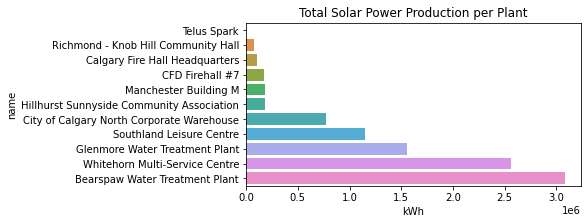

In [220]:
plant_production = solar_df.groupby(["name"])[["kWh"]].sum().sort_values("kWh")
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(data=plant_production.reset_index(), x="kWh", y="name", ax=ax)
ax.set_title("Total Solar Power Production per Plant")
plt.show()

#### Finding Correlation Between Time and Solar Power Production

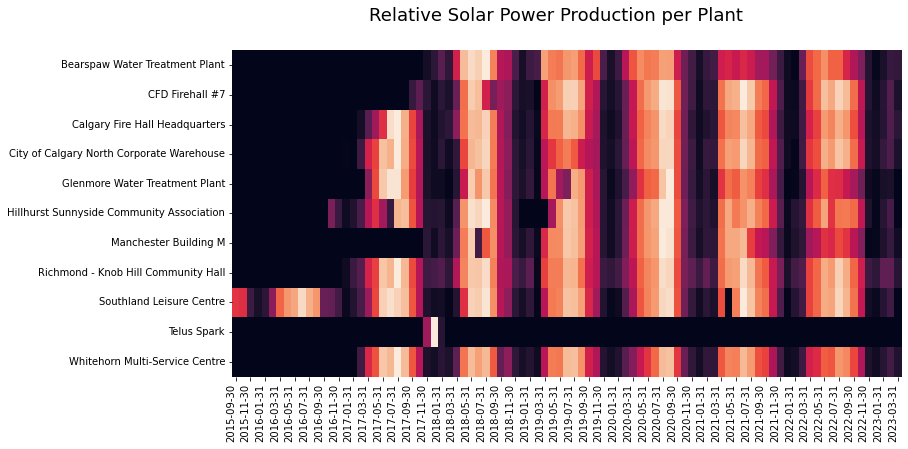

In [221]:
temp_df = solar_df.copy(deep = True)
temp_df.set_index("date", inplace = True)
monthly_energy = temp_df.groupby("name").resample("M").sum()
monthly_filled = monthly_energy.unstack().fillna(0).stack()
total_monthly_energy = monthly_filled.reset_index().pivot_table(index = "name", columns = "date", values = "kWh")
total_monthly_energy = total_monthly_energy.div(total_monthly_energy.max(axis = 1), axis = 0)
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(total_monthly_energy, cbar = False, ax = ax)
x_dates = [x.get_text().split("T")[0] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels = x_dates, rotation = 90, ha = "right")
ax.set(xlabel = None)
ax.set(ylabel = None)
fig.suptitle("Relative Solar Power Production per Plant", fontsize = 18)
plt.show()

From these two graphs, it can be seen that there is an obvious seasonal cycle of how much each solar power plant produces in terms of energy, meaning that it can be predicted with a time-prediction model. Given that the Whitehorn Multi-Service Center has some of the most data, and it produces the second most amount of energy, I shall use it for my data analysis.

## Data Preprocessing

### Filtering for the Chosen Energy Center

In [222]:
solar_df = solar_df.loc[solar_df.name == "Whitehorn Multi-Service Centre", ["date", "kWh"]]

Done to reduce the very high amount of data, as well as to allow the project to focus on predicting for just one plant.

### Combining for Day Frequency to Reduce Amount of Data

In [223]:
solar_df = solar_df.set_index("date")
solar_df = solar_df.resample("d").sum()
solar_df = solar_df.resample("d").asfreq().fillna(0)

Done to reduce the amount of data and make predictions easier.

### Splitting Data into Training and Testing Groups

In [224]:
solar_df['day_of_month'] = solar_df.index.day
solar_df['month'] = solar_df.index.month
solar_df['year'] = solar_df.index.year
solar_df['month_sin'] = np.sin(2 * np.pi * solar_df['month'] / 12)
solar_df['month_cos'] = np.cos(2 * np.pi * solar_df['month'] / 12)     

train_end_date = solar_df.index.min() + pd.DateOffset(years=5)
train_data = solar_df[:train_end_date]
test_data = solar_df[train_end_date:]

feature_cols = ['day_of_month', 'month', 'year', "month_sin", "month_cos"]
X_train = train_data[feature_cols]
y_train = train_data['kWh']
X_test = test_data[feature_cols]
y_test = test_data['kWh']

## Modelling on Dataset

### Creating a Bayesian Optimization Function

In [225]:
def lgbm_evaluate(num_leaves, learning_rate, feature_fraction, bagging_fraction, min_data_in_leaf, min_sum_hessian_in_leaf):
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    lgbm = LGBMRegressor(boosting_type = "gbdt", objective = "regression", num_leaves = num_leaves, learning_rate = learning_rate, \
        feature_fraction=feature_fraction, bagging_fraction = bagging_fraction, min_data_in_leaf = min_data_in_leaf, \
        min_sum_hessian_in_leaf = min_sum_hessian_in_leaf, n_estimators = 100)
    lgbm.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = "rmse")
    y_pred = lgbm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return -rmse

### Finding Best Hyperparameters

In [229]:
param_bounds = {
    'num_leaves': (20, 100),
    'learning_rate': (0.01, 0.3),
    'feature_fraction': (0.1, 0.9),
    'bagging_fraction': (0.8, 1.0),
    'min_data_in_leaf': (5, 50),
    'min_sum_hessian_in_leaf': (0.0, 10.0)
}
optimizer = BayesianOptimization(f = lgbm_evaluate, pbounds = param_bounds, random_state = 42)
optimizer.maximize(init_points = 5, n_iter = 30)

|   iter    |  target   | baggin... | featur... | learni... | min_da... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8605714451279329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8605714451279329
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5601864044243652, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5601864044243652
[LightGBM] [Warning] bagging_fraction is set=0.8749080237694725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749080237694725
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8605714451279329, colsample_bytree=1.0 wil

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.7929409166199481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7929409166199481
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.20584494295802447, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.20584494295802447
[LightGBM] [Warning] bagging_fraction is set=0.8116167224336399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8116167224336399
|  2        | -611.2    |  0.8116   |  0.7929   |  0.1843   |  36.86    |  0.2058   |  97.59    |
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.26987128854262094, colsample_bytree=1.0 will be ignored. Curren

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.728140769114411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.728140769114411
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5.924145688620425, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5.924145688620425
[LightGBM] [Warning] bagging_fraction is set=0.8912139968434072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8912139968434072
|  5        | -572.6    |  0.8912   |  0.7281   |  0.06791  |  28.14    |  5.924    |  23.72    |
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.7081287438321272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7081287438321272
[LightGBM] [Warning] min_sum_hessian_

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.641432309605502, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.641432309605502
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.641432309605502, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.641432309605502
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.4023224276906172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4023224276906172
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.27404854941656787, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.27404854941656787
[LightGBM] [Warning] bagging_fraction is set=0.9541592405276675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9541592405276675
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.4023224276906172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4023224276906172
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.27404854941656787, min_child_weight=0.001 will be ignored. Current value: min_s

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.2835702985723767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2835702985723767
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.9376044718118557, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.9376044718118557
[LightGBM] [Warning] bagging_fraction is set=0.9860641201752653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9860641201752653
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.2835702985723767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2835702985723767
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.9376044718118557, min_child_weight=0.001 will be ignored. Current value: min_sum_

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.079519591453364, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.079519591453364
[LightGBM] [Warning] bagging_fraction is set=0.8082646865041277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082646865041277
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.079519591453364, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.079519591453364
[LightGBM] [Warning] bagg

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.734854644889124, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.734854644889124
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.734854644889124, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.734854644889124
[LightGBM] [Warning] bagging_fraction is set=0.8, subsa

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.9420989360651024, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.9420989360651024
[LightGBM] [Warning] bagging_fraction is set=0.8088355151958054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8088355151958054
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.9420989360651024, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.9420989360651024
[LightGBM] [Warning] 

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.36493189882415966, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.36493189882415966
[LightGBM] [Warning] bagging_fraction is set=0.9108342928887331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108342928887331
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.36493189882415966, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.36493189882415966
[LightGBM] [Warning] 

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.338067177925978, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.338067177925978
[LightGBM] [Warning] bagging_fraction is set=0.9149186814859024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9149186814859024
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.338067177925978, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.338067177925978
[LightGBM] [Warning] bagg

## Model Evaluation

### Creating Model with Best Hyperparameters

In [230]:
best_params = optimizer.max["params"]
best_params["num_leaves"] = int(best_params["num_leaves"])
best_params["min_data_in_leaf"] = int(best_params["min_data_in_leaf"])
lgbm_regressor = LGBMRegressor(boosting_type = "gbdt", objective = "regression", n_estimators = 100, **best_params)
lgbm_regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = "rmse")
y_pred = lgbm_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Optimized Root Mean Squared Error: {rmse:.2f}")

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.4023224276906172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4023224276906172
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.27404854941656787, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.27404854941656787
[LightGBM] [Warning] bagging_fraction is set=0.9541592405276675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9541592405276675
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.4023224276906172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4023224276906172
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.27404854941656787, min_child_weight=0.001 will be ignored. Current value: min_s

### Plotting Predicted vs. Test Values

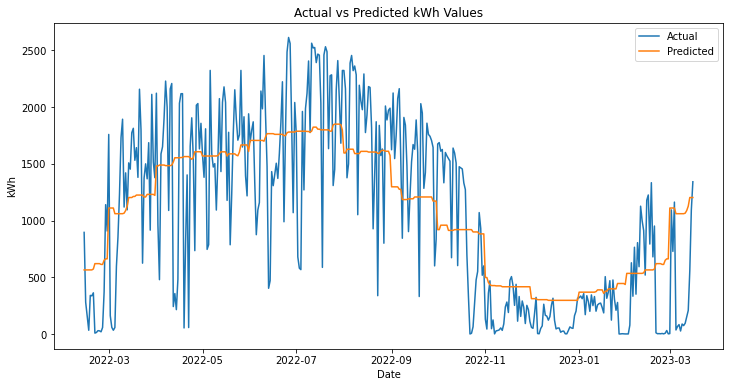

In [231]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted kWh Values')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

There are quite a large amount of random weekly fluctuations but the model correctly predicts the cyclical pattern fairly accurately! It even correctly predicts some of the more major dips and climbs, despite a fairly short training time. For the lack of data and computing power, this model works quite well!